In [1]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model,Input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [3]:
y_val = to_categorical(y_val)

In [4]:
input_shape = X_val[0,:,:,:].shape
model_input = Input(shape=input_shape)

**Xception**

In [5]:
xception = Xception(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

2022-04-22 12:35:04.135311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 12:35:04.217092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 12:35:04.217868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 12:35:04.219071: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
for layer in xception.layers:
    layer.trainable = False

In [7]:
xception_last_layer = xception.get_layer('block14_sepconv2_act')
print('last layer output shape:', xception_last_layer.output_shape)
xception_last_output = xception_last_layer.output

last layer output shape: (None, 6, 8, 2048)


In [8]:
# Flatten the output layer to 1 dimension
x_xception = layers.GlobalMaxPooling2D()(xception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_xception = layers.Dense(512, activation='relu')(x_xception)
# Add a dropout rate of 0.7
x_xception = layers.Dropout(0.5)(x_xception)
# Add a final sigmoid layer for classification
x_xception = layers.Dense(7, activation='softmax')(x_xception)

# Configure and compile the model

xception_model = Model(model_input, x_xception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
xception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
xception_model.load_weights('../input/models/Models/xception.h5')

In [10]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

**DenseNet**

In [11]:
denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [12]:
for layer in denseNet.layers:
    layer.trainable = False

In [13]:
denseNet_last_layer = denseNet.get_layer('relu')
print('last layer output shape:', denseNet_last_layer.output_shape)
denseNet_last_output = denseNet_last_layer.output

last layer output shape: (None, 6, 8, 1920)


In [14]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.5)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(7, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
denseNet_model.load_weights("../input/models/Models/DenseNet.h5")

In [16]:
denseNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
____________________________________________________________________________________________

**InceptionV3**

In [17]:
inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [18]:
for layer in inception.layers:
    layer.trainable = False

In [19]:
inception_last_layer = inception.get_layer('mixed10')
print('last layer output shape:', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [20]:
# Flatten the output layer to 1 dimension
x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_inception = layers.Dense(512, activation='relu')(x_inception)
# Add a dropout rate of 0.7
x_inception = layers.Dropout(0.5)(x_inception)
# Add a final sigmoid layer for classification
x_inception = layers.Dense(7, activation='softmax')(x_inception)

# Configure and compile the model

inception_model = Model(model_input, x_inception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
inception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
inception_model.load_weights("../input/models/Models/InceptionV3.h5")

In [22]:
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 95, 127, 32)  96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

**ResNet50**

In [23]:
resnet = ResNet50(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [24]:
for layer in resnet.layers:
    layer.trainable = False

In [25]:
resnet_last_layer = resnet.get_layer('conv5_block3_out')
print('last layer output shape:', resnet_last_layer.output_shape)
resnet_last_output = resnet_last_layer.output

last layer output shape: (None, 6, 8, 2048)


In [26]:
# Flatten the output layer to 1 dimension
x_resnet = layers.GlobalMaxPooling2D()(resnet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_resnet = layers.Dense(512, activation='relu')(x_resnet)
# Add a dropout rate of 0.7
x_resnet = layers.Dropout(0.5)(x_resnet)
# Add a final sigmoid layer for classification
x_resnet = layers.Dense(7, activation='softmax')(x_resnet)

# Configure and compile the model

resnet_model = Model(model_input, x_resnet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
resnet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
resnet_model.load_weights("../input/models/Models/ResNet.h5")

In [28]:
resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 128, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1_conv[0][0]                 
____________________________________________________________________________________________

**Vgg16**

In [29]:
vgg16 = VGG19(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [30]:
for layer in vgg16.layers:
    layer.trainable = False

In [31]:
vgg_last_layer = vgg16.get_layer('block5_pool')
print('last layer output shape:', vgg_last_layer.output_shape)
vgg_last_output = vgg_last_layer.output

last layer output shape: (None, 6, 8, 512)


In [32]:
# Flatten the output layer to 1 dimension
x_vgg = layers.GlobalMaxPooling2D()(vgg_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_vgg = layers.Dense(512, activation='relu')(x_vgg)
# Add a dropout rate of 0.7
x_vgg = layers.Dropout(0.5)(x_vgg)
# Add a final sigmoid layer for classification
x_vgg = layers.Dense(7, activation='softmax')(x_vgg)

# Configure and compile the model

vgg_model = Model(model_input, x_vgg)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [33]:
vgg_model.load_weights("../input/models/Models/vgg16.h5")

In [34]:
vgg_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0   

**EfficientNet**

In [35]:
efficientNet=tf.keras.applications.EfficientNetB4(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [36]:
for layer in efficientNet.layers:
    layer.trainable = False

In [37]:
last_layer = efficientNet.get_layer('top_activation')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1792)


In [38]:
# Flatten the output layer to 1 dimension
x_eff = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_eff = layers.Dense(512, activation='relu')(x_eff)
# Add a dropout rate of 0.5
x_eff = layers.Dropout(0.5)(x_eff)
# Add a final sigmoid layer for classification
x_eff = layers.Dense(7, activation='softmax')(x_eff)

eff_model = Model(model_input, x_eff)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
eff_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [39]:
eff_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 192, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 192, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 257, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [40]:
eff_model.load_weights("../input/../input/efficientb4/EfficientNetB4.h5")

In [41]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")




In [42]:
out_incep=inception_model.predict(X_test)
out_xcep=xception_model.predict(X_test)
out_eff=eff_model.predict(X_test)
pred1=np.argmax(out_incep, axis=1)
pred2=np.argmax(out_xcep, axis=1)
pred3=np.argmax(out_eff, axis=1)

2022-04-22 12:39:15.038629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-22 12:39:16.868794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [43]:
from sklearn.metrics import accuracy_score
incep_acu=accuracy_score(y_test,pred1)
xcep_acu=accuracy_score(y_test, pred2)
eff_acu=accuracy_score(y_test, pred3)
print('Inception Accuracy= ',incep_acu)
print('Xception Accuracy= ',xcep_acu)
print('EfficientNet Accuracy= ',eff_acu)

Inception Accuracy=  0.8662674650698603
Xception Accuracy=  0.8582834331337326
EfficientNet Accuracy=  0.8542914171656687


In [44]:
preds=[out_incep,out_xcep,out_eff]
preds=np.array(preds)


In [45]:
preds

array([[[3.33622843e-12, 1.27046689e-13, 1.30396527e-10, ...,
         9.99994040e-01, 5.99142806e-13, 5.94060111e-06],
        [3.17524450e-06, 3.20764002e-06, 2.73058075e-04, ...,
         9.94677186e-01, 3.02173635e-06, 5.03701298e-03],
        [2.34811064e-15, 1.02635033e-14, 4.92197103e-13, ...,
         1.00000000e+00, 5.58943701e-15, 2.48092036e-09],
        ...,
        [2.35438943e-11, 1.30053234e-11, 6.98918035e-10, ...,
         1.00000000e+00, 1.75637673e-12, 2.01846042e-08],
        [4.22869323e-10, 6.16871976e-09, 4.59134412e-07, ...,
         9.99936819e-01, 2.77691425e-09, 6.26677211e-05],
        [4.07639928e-02, 4.83292252e-01, 1.11168614e-02, ...,
         1.88301250e-01, 4.44917066e-04, 1.81061134e-01]],

       [[3.43247899e-16, 4.95850123e-16, 4.73608349e-13, ...,
         9.99999285e-01, 1.27739548e-14, 7.00260955e-07],
        [1.53747559e-09, 1.01529445e-10, 2.61706714e-06, ...,
         9.99963045e-01, 1.98082911e-10, 3.43343163e-05],
        [4.33249793e-23, 

In [46]:
df=pd.DataFrame([])
for w1 in range(0, 20):
    for w2 in range(0,20):
        for w3 in range(0,20):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_test, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         

Max accuracy of  89.22155688622755  obained with w1= 0.6  w2= 0.4  and w3= 0.7


In [47]:
weights=[0.6,0.4,0.7]
summed=np.sum(preds,axis=0)
ensemble_pred=np.argmax(summed,axis=1)
weighted_pred=np.tensordot(preds,weights,axes=((0),(0)))
weighted_ensemble_pred=np.argmax(weighted_pred,axis=1)

In [48]:
from sklearn.metrics import accuracy_score
ensemble_accuracy=accuracy_score(y_test, ensemble_pred)
weighted_ensemble_accuracy=accuracy_score(y_test, weighted_ensemble_pred)
print('Ensemble Accuracy= ',ensemble_accuracy)
print('Weighted Ensemble Accuracy= ',weighted_ensemble_accuracy)

Ensemble Accuracy=  0.8842315369261478
Weighted Ensemble Accuracy=  0.8922155688622755


In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt


In [50]:
ecm = confusion_matrix(y_test, ensemble_pred)
print(ecm)

[[ 13   1  11   1   1   0   1]
 [  1  39  11   0   5   0   1]
 [  1   0  87   0  11   0   9]
 [  0   0   1  13   1   0   0]
 [  0   1  13   0 653   1  10]
 [  0   0   0   1   0  13   0]
 [  0   0  11   1  22   0  68]]


In [51]:
wecm=confusion_matrix(y_test, weighted_ensemble_pred)
print(wecm)

[[ 13   1  11   1   1   0   1]
 [  1  40   9   0   5   0   2]
 [  1   0  87   0  10   0  10]
 [  0   0   1  13   1   0   0]
 [  0   1  12   0 656   0   9]
 [  0   0   0   0   0  14   0]
 [  0   1   6   1  23   0  71]]


In [52]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ensemble_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.46      0.60        28
     class 1       0.95      0.68      0.80        57
     class 2       0.65      0.81      0.72       108
     class 3       0.81      0.87      0.84        15
     class 4       0.94      0.96      0.95       678
     class 5       0.93      0.93      0.93        14
     class 6       0.76      0.67      0.71       102

    accuracy                           0.88      1002
   macro avg       0.84      0.77      0.79      1002
weighted avg       0.89      0.88      0.88      1002



In [54]:
print(classification_report(y_test, weighted_ensemble_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.46      0.60        28
     class 1       0.93      0.70      0.80        57
     class 2       0.69      0.81      0.74       108
     class 3       0.87      0.87      0.87        15
     class 4       0.94      0.97      0.95       678
     class 5       1.00      1.00      1.00        14
     class 6       0.76      0.70      0.73       102

    accuracy                           0.89      1002
   macro avg       0.87      0.79      0.81      1002
weighted avg       0.89      0.89      0.89      1002



In [55]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,ensemble_pred,average='weighted' )

print("Ensemble: Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Ensemble: Sensitivity: 88.42% specificity 90.82%


In [56]:
result = sensitivity_specificity_support(y_test,weighted_ensemble_pred,average='weighted' )

print("Weighted_Ensemble: Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Weighted_Ensemble: Sensitivity: 89.22% specificity 90.90%


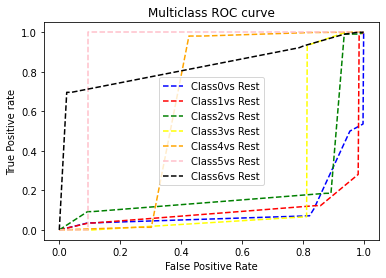

In [57]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, weighted_ensemble_pred, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);
